# Open Traffic Reporter

## Map-Matching Optimization

The Open Traffic Reporter map-matching service is based on the Hidden Markov Model (HMM) design of [Newton and Krumm (2009)](http://research.microsoft.com/en-us/um/people/jckrumm/Publications%202009/map%20matching%20ACM%20GIS%20camera%20ready.pdf). Skipping over 99% of the innerworkings of HMMs, there are two principal parameters in the HMM algorithm that must be estimated from data (for more detail see [here](https://en.wikipedia.org/wiki/Hidden_Markov_model)).

The first parameter that needs tuning is $\sigma_z$. It appears in the equation below which expresses the probability of recording the GPS measurement $z_t$ from road segment $r_i$. 

$$ p(z_t|r_i) = \frac{1}{\sqrt{2 \pi \sigma_z}} e^{-0.5(\frac{||z_t - x_{t,i}||_{\text{great circle}}}{\sigma_z})^2}$$

In [1]:
from __future__ import division
from matplotlib import pyplot as plt
import numpy as np
import os
import urllib
import json
import pandas as pd
from random import shuffle, choice
import pickle
import sys; sys.path.insert(0, os.path.abspath('..'));
import validator.validator as val
%matplotlib inline

In [2]:
mapzenKey = os.environ.get('MAPZEN_API')
gmapsKey = os.environ.get('GOOGLE_MAPS')

### 1. Generate Random Routes

#### Generate routes from Google Maps POIs or Mapzen Venues

In [3]:
# routeList = val.get_POI_routes_by_length('Paris', 1, 5, 20, gmapsKey)
routeList = val.get_routes_by_length('San Francisco', 1, 5, 20, mapzenKey)

#### Save or load a specific set of routes

In [ ]:
# routeList = pickle.load(open('sf_routes.pkl','rb'))
# pickle.dump(routeList, open('saf_routes.pkl','wb'))

### 2. Grid Search for Optimal Parameter Values

In [53]:
np.linspace(0,50,26)

array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
        22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
        44.,  46.,  48.,  50.])

In [123]:
df = pd.DataFrame(columns=['beta', 'sigma_z', 'score'])
outDfRow = -1
saveResults = False
noiseLevels = np.linspace(0, 100, 21)
noiseLevels = [50]
sampleRates = [1, 5, 10, 20, 30]
sampleRates = [10]
betas = np.linspace(0,50,26)
sigmaZs = np.linspace(0,50,26)
tpf = 500

for i, rteCoords in enumerate(routeList):
    print("Processig route {0} of {1}".format(i, len(routeList)))
    shape, routeUrl = val.get_route_shape(rteCoords)
    
    for beta in betas:
        
        for sigmaZ in sigmaZs:
            print("Computing score for sigma_z: {0}, beta: {1}".format(
                        sigmaZ, beta))
            edges, shapeCoords, traceAttrUrl = val.get_trace_attrs(
                shape, turnPenaltyFactor=tpf, beta=beta, sigmaZ=sigmaZ)
            edges = val.get_coords_per_second(shapeCoords, edges, '2768')

            for noise in noiseLevels:
                noise = round(noise,3)

                for sampleRate in sampleRates:
                    outDfRow += 1
                    df.loc[outDfRow, ['beta','sigma_z']] = [beta, sigmaZ]
                    dfEdges = val.format_edge_df(edges)
                    dfEdges, jsonDict, geojson, gpsMatchEdges = val.synthesize_gps(
                        dfEdges, shapeCoords, '2768', noise=noise, sampleRate=sampleRate, 
                        turnPenaltyFactor=tpf, beta=beta, sigmaZ=sigmaZ)
                    segments, reportUrl = val.get_reporter_segments(jsonDict)
                    matches, segScore, distScore = val.get_match_scores(segments, dfEdges, gpsMatchEdges)
                    df.loc[outDfRow, 'score'] = distScore

                    if saveResults:
                        matches.to_csv(
                            '../data/matches_{0}_to_{1}_w_{2}_m_noise_at_{3}_Hz.csv'.format(
                                stName, endName, str(noise), str(Hz)), index=False)
                        with open('../data/trace_{0}_to_{1}_w_{2}_m_noise_at_{3}_Hz.geojson'.format(
                            stName, endName, str(noise), str(Hz)), 'w+') as fp:
                            json.dump(geojson, fp)

Processig route 0 of 20
Computing score for sigma_z: 0.0, beta: 0.0
Computing score for sigma_z: 2.0, beta: 0.0
Computing score for sigma_z: 4.0, beta: 0.0
Computing score for sigma_z: 6.0, beta: 0.0
Computing score for sigma_z: 8.0, beta: 0.0
Computing score for sigma_z: 10.0, beta: 0.0
Computing score for sigma_z: 12.0, beta: 0.0
Computing score for sigma_z: 14.0, beta: 0.0
Computing score for sigma_z: 16.0, beta: 0.0
Computing score for sigma_z: 18.0, beta: 0.0
Computing score for sigma_z: 20.0, beta: 0.0
Computing score for sigma_z: 22.0, beta: 0.0
Computing score for sigma_z: 24.0, beta: 0.0
Computing score for sigma_z: 26.0, beta: 0.0
Computing score for sigma_z: 28.0, beta: 0.0
Computing score for sigma_z: 30.0, beta: 0.0
Computing score for sigma_z: 32.0, beta: 0.0
Computing score for sigma_z: 34.0, beta: 0.0
Computing score for sigma_z: 36.0, beta: 0.0
Computing score for sigma_z: 38.0, beta: 0.0
Computing score for sigma_z: 40.0, beta: 0.0
Computing score for sigma_z: 42.0, b

### 3. Plot the Curves

In [124]:
df['score'] = df['score'].astype(float)
df['beta'] = df['beta'].astype(float)
df['sigma_z'] = df['sigma_z'].astype(float)

In [125]:
betaScores = df.groupby('beta').agg('mean').reset_index()

In [126]:
sigmaZScores = df.groupby('sigma_z').agg('mean').reset_index()

In [127]:
scores = np.ones((len(betaScores), len(sigmaZScores)))

In [128]:
for i, beta in enumerate(betas):
    for j, sigmaZ in enumerate(sigmaZs):
        scores[i,j] = df.loc[(df['beta'] == beta) & (df['sigma_z'] == sigmaZ), 'score'].values[0]

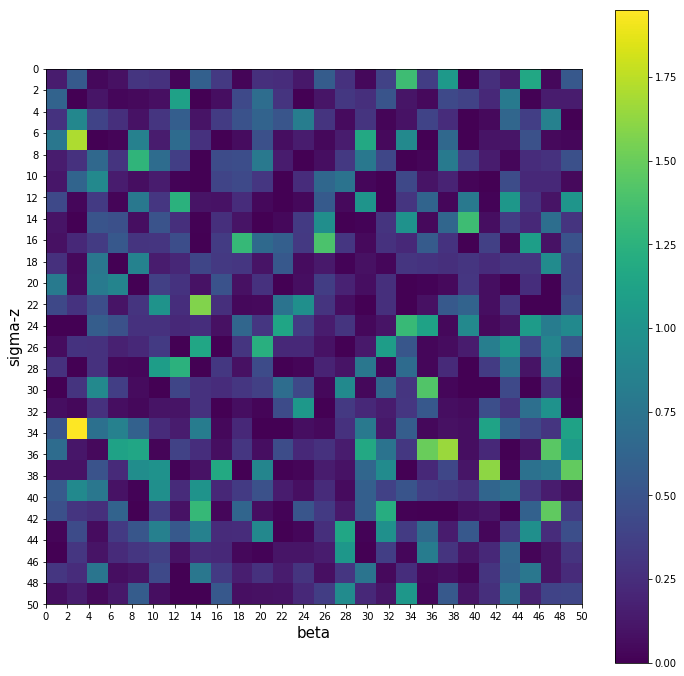

In [129]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(scores, interpolation='none', extent=[0,50,50,0])
plt.colorbar(im, ax=ax)
ax.set_xlabel("beta", fontsize=15)
ax.set_ylabel("sigma-z", fontsize=15)
ax.set_xticks(betas)
ax.set_yticks(sigmaZs)
ax.set_xticklabels(map(int, betas))
ax.set_yticklabels(map(int, sigmaZs))
plt.show()